# **1. Install and Import Libraries**
Dalam penggunaan Google Collab, sebelum menggunakan fitur-fitur yang tersedia dalam library yang sudah dijelaskan sebelumnya (NumPy, Matplotlib, dsb.), library yang ingin digunakan harus di-import terlebih dahulu demgam menggunakan syntax:

`import namaLibrary as abc`

Bagian syntax "as abc" opsional, namun khususnya bagian "abc" biasanya sudah ada best practice penamaan library (Seperti np untuk NumPy, pd untuk Pandas, dsb.) dan akan teman-teman gunakan untuk "memanggil" fungsi (fitur) yang ditawarkan sebuah library.

In [1]:
%pip install scikit-learn
%pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from bayes_opt import BayesianOptimization

# **2. Data Loading**

Data shape: (1827, 11)

First few rows:
                   pm2p5          pm10      tcco         tcno2     gtco3  \
date                                                                       
2020-01-01  1.117303e-08  1.581350e-08  0.000842  8.595702e-07  0.005310   
2020-01-02  1.020425e-08  1.448988e-08  0.000846  8.332591e-07  0.005313   
2020-01-03  1.245803e-08  1.731650e-08  0.000844  8.671530e-07  0.005310   
2020-01-04  1.430548e-08  1.921870e-08  0.000843  8.642510e-07  0.005325   
2020-01-05  1.466172e-08  1.937695e-08  0.000832  8.476774e-07  0.005348   

                   tcso2  Day  Jumlah_Kasus_TB    Bulan  Tahun  Bulan_Angka  
date                                                                         
2020-01-01  4.195158e-07    1             1414  2020-01   2020            1  
2020-01-02  4.175671e-07    2             1414  2020-01   2020            1  
2020-01-03  4.265508e-07    3             1414  2020-01   2020            1  
2020-01-04  4.496984e-07    4        

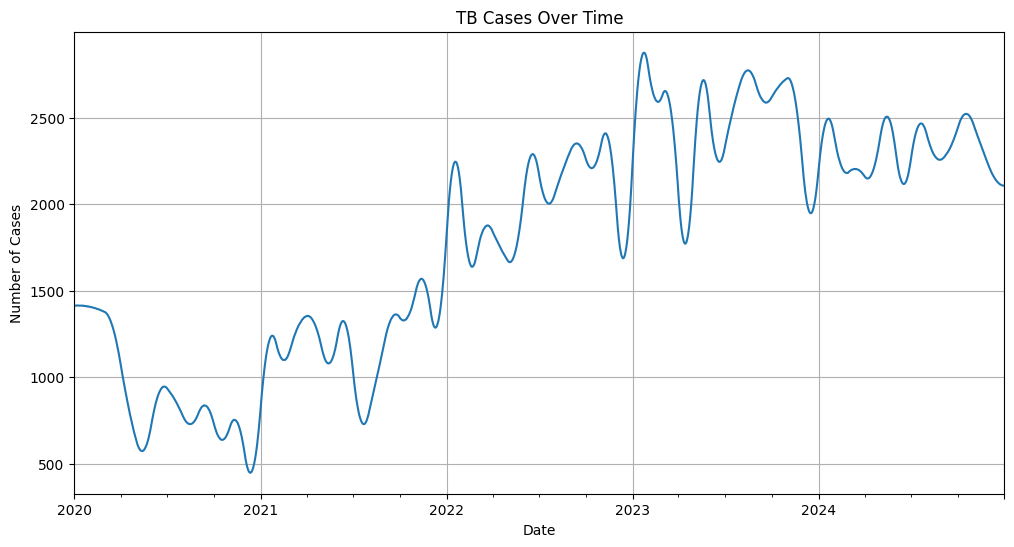


Missing values:
pm2p5              0
pm10               0
tcco               0
tcno2              0
gtco3              0
tcso2              0
Day                0
Jumlah_Kasus_TB    0
Bulan              0
Tahun              0
Bulan_Angka        0
dtype: int64


In [4]:
# 1. Load data dan set index
df = pd.read_csv('data_merge.csv')
df['date'] = pd.to_datetime(df['Unnamed: 0'])  # Konversi ke datetime
df = df.set_index('date')  # Set sebagai index
df = df.drop('Unnamed: 0', axis=1)  # Hapus kolom asli

# 2. Sort berdasarkan tanggal
df = df.sort_index()

# 3. Cek hasil
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# 4. Cek info data
print("\nData info:")
print(df.info())

# 5. Visualisasi data
plt.figure(figsize=(12, 6))
df['Jumlah_Kasus_TB'].plot()
plt.title('TB Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.show()

# 6. Cek missing values
print("\nMissing values:")
print(df.isnull().sum())

# **3. Data Preprocessing**

In [5]:
# Data Preprocessing
print("\nPreprData Preprocessingocessing data...")

# Create time features
df['month_sin'] = np.sin(2 * np.pi * df['Bulan_Angka']/12)
df['month_cos'] = np.cos(2 * np.pi * df['Bulan_Angka']/12)
df['day_of_week'] = df.index.to_series().dt.dayofweek
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)



PreprData Preprocessingocessing data...


## **Create lag features**

In [8]:
# Create lag features
target_col = 'Jumlah_Kasus_TB'
lag_list = [1, 7, 14, 30]
for lag in lag_list:
    df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

# Drop rows with NaN values
df = df.dropna()

C:\Users\hp\AppData\Local\Temp\ipykernel_30424\3429876112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)


# **4. Prepare Features and Target**

## **Define feature columns (excluding date and target)**

In [9]:
# Define feature columns (excluding date and target)
feature_cols = [col for col in df.columns if col not in ['date', target_col, 'Day', 'Bulan', 'Tahun', 'Bulan_Angka']]
X = df[feature_cols].values
y = df[target_col].values

## **Normalize Data**

In [10]:
print("\nNormalizing data...")
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()


Normalizing data...


## **Create Sequences**

In [17]:

print("\nCreating sequences...")
time_steps = 14
X_seq, y_seq = [], []
for i in range(len(X_scaled) - time_steps):
    X_seq.append(X_scaled[i:i + time_steps])
    y_seq.append(y_scaled[i + time_steps])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


Creating sequences...


## **Split Data*

In [18]:
print("\nSplitting data...")
train_size = int(0.7 * len(X_seq))
val_size = int(0.15 * len(X_seq))

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_val = X_seq[train_size:train_size+val_size]
y_val = y_seq[train_size:train_size+val_size]
X_test = X_seq[train_size+val_size:]
y_test = y_seq[train_size+val_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")


Splitting data...
Training data shape: (1227, 14, 15)
Validation data shape: (262, 14, 15)
Testing data shape: (264, 14, 15)


# **Define Model Architecture**

In [19]:
def build_model(input_shape, gru_units=64, dropout_rate=0.2, 
                filters_1=64, filters_2=128, kernel_size=3):
    model = Sequential()
    
    # First CNN block
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size,
                    strides=1, padding='causal', activation='relu',
                    input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # Second CNN block
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size,
                    padding='causal', activation='relu', dilation_rate=2))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # GRU layers
    model.add(GRU(units=gru_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=gru_units))
    model.add(Dropout(dropout_rate))
    
    # Output layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(1))
    
    return model

## **Bayesian Optimization**

In [20]:
print("\nPerforming Bayesian Optimization...")

def objective_function(gru_units, dropout_rate, learning_rate, batch_size, 
                      filters_1, filters_2, kernel_size):
    # Convert parameters to appropriate types
    gru_units = int(gru_units)
    batch_size = int(batch_size)
    filters_1 = int(filters_1)
    filters_2 = int(filters_2)
    kernel_size = int(kernel_size)
    
    # Create and compile model
    model = build_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        filters_1=filters_1,
        filters_2=filters_2,
        kernel_size=kernel_size
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=50,
        verbose=0
    )
    
    
    return -min(history.history['val_loss'])



Performing Bayesian Optimization...


## **Define parameter bounds**

In [21]:
pbounds = {
    'gru_units': (32, 256),
    'dropout_rate': (0.1, 0.5),
    'learning_rate': (0.0001, 0.01),
    'batch_size': (16, 128),
    'filters_1': (32, 128),
    'filters_2': (64, 256),
    'kernel_size': (2, 5)
}

## **Run Bayesian Optimization**

In [22]:
from bayes_opt import BayesianOptimization

# Buat optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=1
)

# Jalankan optimisasi
optimizer.maximize(
    init_points=5,  # Number of initial random points
    n_iter=20      # Number of optimization iterations
)

# Ambil parameter terbaik
best_params = optimizer.max['params']
print("\nBest hyperparameters:", best_params)

|   iter    |  target   | batch_... | dropou... | filters_1 | filters_2 | gru_units | kernel... | learni... |
-------------------------------------------------------------------------------------------------------------


| 1         | -0.03273  | 62.71     | 0.3881    | 32.01     | 122.0     | 64.87     | 2.277     | 0.001944  |
| 2         | -0.0373   | 54.7      | 0.2587    | 83.73     | 144.5     | 185.5     | 2.613     | 0.008793  |
| 3         | -0.06875  | 19.07     | 0.3682    | 72.06     | 171.3     | 63.45     | 2.594     | 0.008027  |
| 4         | -0.1043   | 124.4     | 0.2254    | 98.46     | 232.3     | 232.4     | 2.255     | 0.0004866 |
| 5         | -0.06202  | 35.02     | 0.4513    | 41.44     | 144.9     | 246.6     | 3.599     | 0.00695   |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 6         | -0.0415   | 60.18     | 0.1142    | 34.37     | 126.5     | 64.62     | 2.354     | 0.007886  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 7         | -0.02876  | 82.71     | 0.2627    | 35.86     | 108.5     | 75.27     | 4.297     | 0.001726  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 8         | -0.04328  | 67.68     | 0.3306    | 33.68     | 91.9      | 44.18     | 2.325     | 0.009694  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 9         | -0.02988  | 43.99     | 0.472     | 38.42     | 91.7      | 90.96     | 4.496     | 0.003531  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 10        | -0.03018  | 82.99     | 0.2774    | 32.01     | 99.62     | 117.0     | 3.124     | 0.004331  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 11        | -0.03518  | 57.48     | 0.3287    | 62.47     | 104.4     | 141.0     | 2.006     | 0.008505  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 12        | -0.03736  | 68.76     | 0.301     | 70.59     | 71.0      | 103.5     | 3.572     | 0.002831  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 13        | -0.1047   | 110.3     | 0.3631    | 70.39     | 122.3     | 146.0     | 4.246     | 0.007305  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 14        | -0.09414  | 56.14     | 0.2494    | 32.99     | 71.51     | 124.8     | 2.264     | 0.00217   |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 15        | -0.07586  | 64.78     | 0.3709    | 45.26     | 110.0     | 98.88     | 3.97      | 0.006112  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 16        | -0.03544  | 84.11     | 0.2145    | 32.15     | 118.9     | 65.44     | 2.092     | 0.003455  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 17        | -0.06424  | 64.22     | 0.1817    | 34.78     | 95.37     | 72.28     | 2.697     | 0.009795  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 18        | -0.03205  | 35.71     | 0.4622    | 50.04     | 81.78     | 84.6      | 4.187     | 0.007775  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 19        | -0.04006  | 28.81     | 0.4616    | 32.24     | 89.7      | 77.64     | 3.675     | 0.007795  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 20        | -0.1146   | 33.64     | 0.3041    | 52.44     | 99.77     | 81.33     | 3.78      | 0.007061  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 21        | -0.02995  | 33.83     | 0.3786    | 36.84     | 77.37     | 83.46     | 2.197     | 0.007921  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 22        | -0.05756  | 41.69     | 0.332     | 36.16     | 81.38     | 95.41     | 2.448     | 0.004447  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 23        | -0.07686  | 74.31     | 0.1701    | 39.52     | 114.0     | 73.51     | 2.565     | 0.0001468 |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 24        | -0.01918  | 79.73     | 0.1677    | 37.88     | 101.1     | 119.7     | 3.143     | 0.002447  |


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 25        | -0.092    | 82.63     | 0.4159    | 42.16     | 105.1     | 127.3     | 4.307     | 0.005422  |

Best hyperparameters: {'batch_size': 79.72568735184302, 'dropout_rate': 0.16766412285648774, 'filters_1': 37.878775675282526, 'filters_2': 101.11885584120908, 'gru_units': 119.71254219901249, 'kernel_size': 3.1431887841964143, 'learning_rate': 0.002447299240743248}


# **Train Final Model**

In [23]:
print("\nTraining final model...")

# Build final model with best parameters
final_model = build_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    gru_units=int(best_params['gru_units']),
    dropout_rate=best_params['dropout_rate'],
    filters_1=int(best_params['filters_1']),
    filters_2=int(best_params['filters_2']),
    kernel_size=int(best_params['kernel_size'])
)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
final_model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Train model
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=int(best_params['batch_size']),
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


Training final model...
Epoch 1/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4198 - mae: 0.4913 - rmse: 0.6310
Epoch 1: val_loss improved from inf to 0.74109, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 0.3980 - mae: 0.4763 - rmse: 0.6137 - val_loss: 0.7411 - val_mae: 0.8130 - val_rmse: 0.8609 - learning_rate: 0.0024
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1071 - mae: 0.2600 - rmse: 0.3265
Epoch 2: val_loss improved from 0.74109 to 0.68404, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1062 - mae: 0.2589 - rmse: 0.3251 - val_loss: 0.6840 - val_mae: 0.7830 - val_rmse: 0.8271 - learning_rate: 0.0024
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0631 - mae: 0.2007 - rmse: 0.2512
Epoch 3: val_loss improved from 0.68404 to 0.52212, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0630 - mae: 0.2003 - rmse: 0.2509 - val_loss: 0.5221 - v

# **Evaluate Final Model**


Evaluating model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step

Model Evaluation Metrics:
MSE: 42424.5127
RMSE: 205.9721
MAE: 170.3171
R²: -1.6548


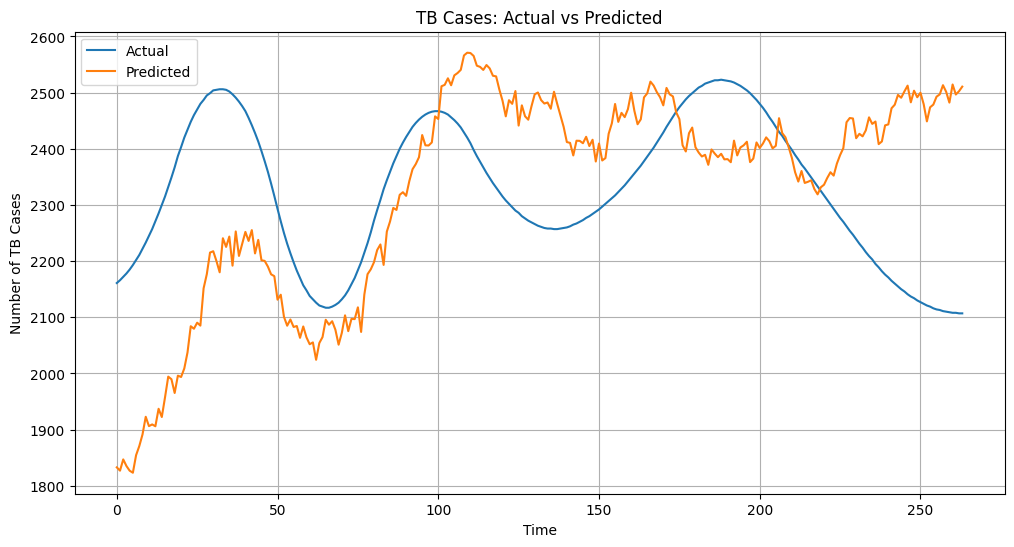

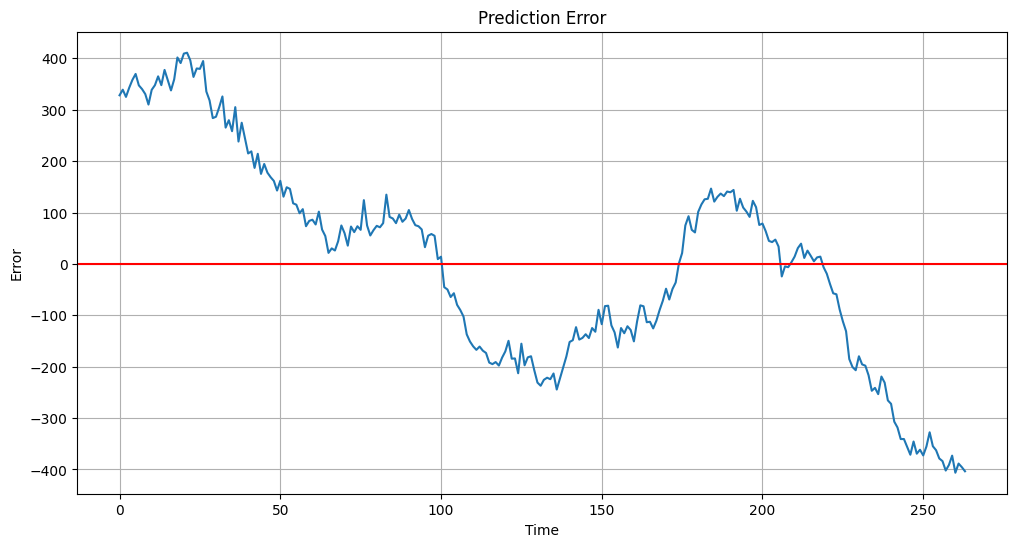

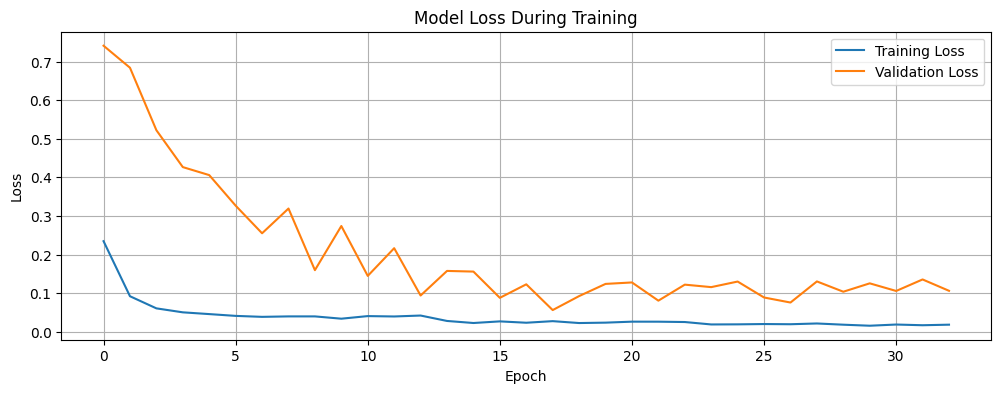

In [24]:
# 10. Evaluate Model
print("\nEvaluating model...")

# Make predictions
y_pred = final_model.predict(X_test)

# Inverse transform predictions
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred).flatten()

# Calculate metrics
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("\nModel Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 11. Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual')
plt.plot(y_pred_orig, label='Predicted')
plt.title('TB Cases: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Number of TB Cases')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediction error
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig - y_pred_orig)
plt.title('Prediction Error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()